In [1]:
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import ctd
import glob
import cmocean.cm as cmo
import cartopy.crs as ccrs
import matplotlib as mpl
import cartopy.feature as cfeature
import geopandas as gpd
import gsw
import warnings
from matplotlib.lines import Line2D
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
warnings.filterwarnings("ignore")

font = {'family' : 'Avenir',
        'weight' : 'normal',
        'size'   : 20}
mpl.rc('font', **font)

In [2]:
def add_features(ax):
    
    ax.add_feature(cfeature.LAND,   facecolor='0.8',edgecolor='k',zorder=3)
    ax.add_feature(cfeature.RIVERS, edgecolor='w'  ,zorder=3)
    ax.add_feature(cfeature.LAKES,  facecolor='w'  ,zorder=3)
    ax.set(xlabel='',ylabel='')
    
    gls = ax.gridlines(crs=ccrs.PlateCarree(), 
                        draw_labels=True,
                        x_inline=False, 
                        y_inline=False,
                        linewidth=0.75,
                        alpha=0.75, 
                        linestyle='--',
                        lw=0,
                        color='k',
                        ylocs=mpl.ticker.MultipleLocator(base=2.5),
                        xlocs=mpl.ticker.MultipleLocator(base=2.5))

    gls.top_labels = False
    gls.bottom_labels = True
    gls.right_labels = False    
    gls.left_labels = True
    gls.xpadding=10
    gls.ypadding=10
    for k, spine in ax.spines.items():  #ax.spines is a dictionary
        spine.set_zorder(10)

def add_swath(ax):
    Swath = ax.add_geometries(swath.geometry, crs=ccrs.PlateCarree(),zorder=4)
    Swath._kwargs['facecolor'] = 'w'
    Swath._kwargs['edgecolor'] = 'k'
    Swath._kwargs['alpha'] = 0.2

# **1. Plot sections**

In [16]:
ds = xr.open_dataset('/Users/xedhjo/Documents/Projects/QUICCHE/data/CTD/QUICCHE_CTDs.nc')
swath = gpd.read_file('/Users/xedhjo/Documents/Projects/QUICCHE/web-portal/data/swot/swot_calval_orbit_june2015-v2_swath.shp')
bathy = xr.open_dataset('/Users/xedhjo/Documents/Projects/QUICCHE/data/gebco_2022_n-30.0_s-45.0_w0.0_e25.0.nc')
bathy = bathy.interp(lon=np.arange(0,25,.05),lat=np.arange(-45,-30,.05))

n = ds.station.max().values
cmap_stn = plt.get_cmap('viridis',n)

To be able to plot nice sections, we first need to merge down- and upcast profiles. The convention is that downcast has a station number that is a whole number, e.g., 1,2,3, while upcasts will have an offset of 0.5, e.g., 1.5, 2.5, 3.5 etc.

Text(0.5, 1.0, 'QUICCHE CTDs')

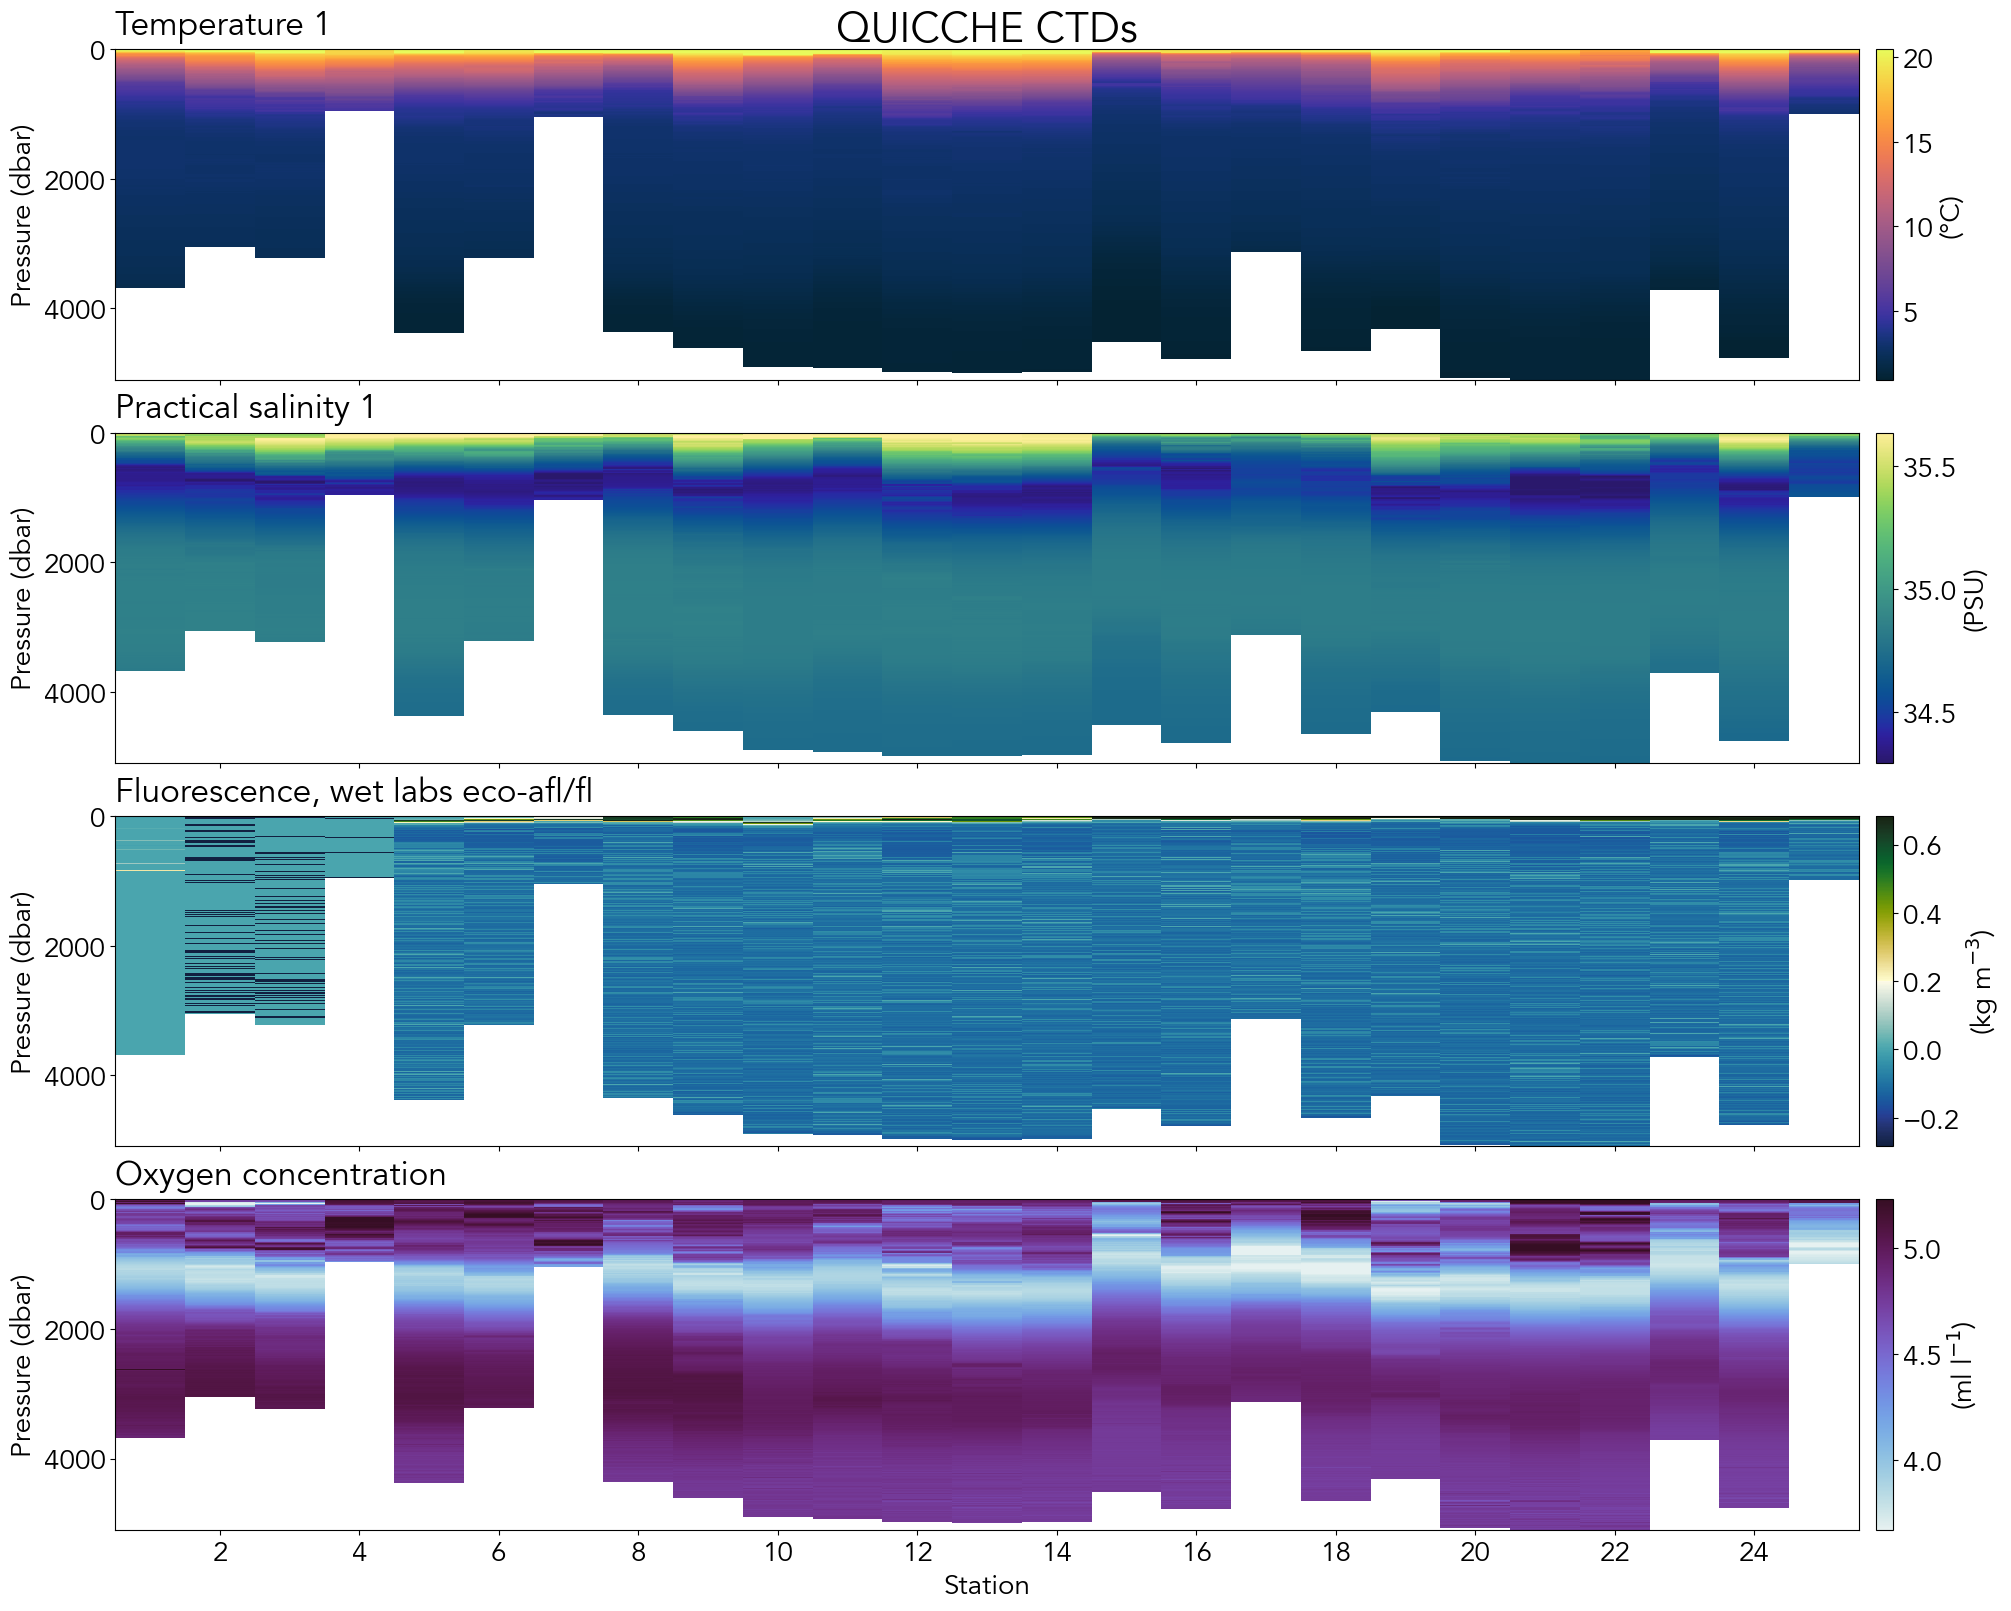

In [25]:
var = ['temperature1','salinity1','chlorophyll','oxygen_concentration_mll']
cmap = [cmo.thermal,cmo.haline,cmo.delta,cmo.dense,'cmo.solar']

fig, ax = plt.subplots(len(var),1,figsize=(20,4*len(var)),sharex=True,constrained_layout=True)

for i,axs in enumerate(ax):
    z = ds[var[i]].mean('cast').squeeze()
    pcm = z.plot(y='pressure',cmap=cmap[i], ax=ax[i], add_colorbar=False,vmin=np.nanpercentile(z.data, 0.5),vmax = np.nanpercentile(z.data, 99.5))
    cb = plt.colorbar(pcm,label=f"({ds[var[i]].units})",pad=0.01)
    axs.set_title(ds[var[i]].attrs['long_name'].capitalize(),loc='left',y=1.02)
    axs.set(xlabel='',ylabel='Pressure (dbar)',xticks=np.arange(2,n+1,2))
    axs.invert_yaxis()
    if i > 0:
        axs.set_title('')

axs.set(xlabel='Station')
ax[0].set_title('QUICCHE CTDs',fontsize=30)

# **2. Plot T/S-plots**

**Calculate a grid of density to use as a contour**

In [26]:
mint=np.min(ds['temperature1'])
maxt=np.max(ds['temperature1'])

mins=np.min(ds['salinity1'])
maxs=np.max(ds['salinity1'])

tempL=np.linspace(mint-1,maxt+1,1000)

salL=np.linspace(mins-1,maxs+1,1000)

Tg, Sg = np.meshgrid(tempL,salL)
sigma_theta = gsw.sigma0(Sg, Tg)
cnt = np.linspace(sigma_theta.min(), sigma_theta.max(),1000)

In [71]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

colors = ListedColormap(['k','k','k','k','k','k','k','k','k','k','k',
          'k','k','k','k','k','k','crimson','crimson','crimson','crimson','crimson','crimson','crimson','crimson','k','k',])

Text(18.4241, -33.9249, '  Cape Town')

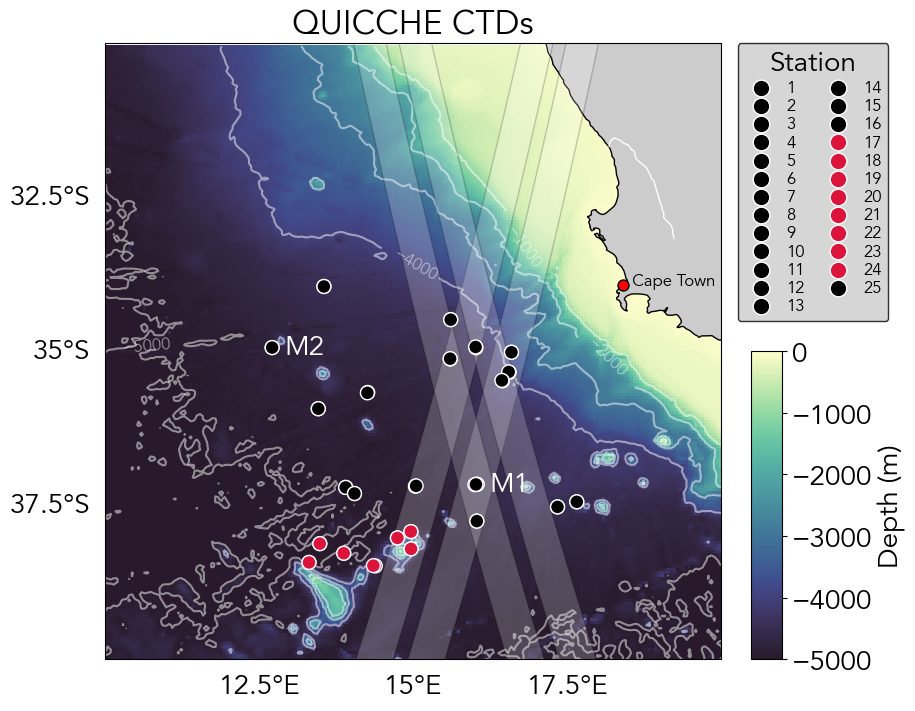

In [72]:
fig,ax=plt.subplots(figsize=(12,8),subplot_kw={'projection':ccrs.PlateCarree()})
bt = bathy.elevation.plot(cmap=cmo.deep_r,vmin=-5000,vmax=0,add_colorbar=False)

#bathy.elevation.plot.contour(levels=np.arange(-5000,0,500)[np.arange(-5000,0,500)%1000 != 0],colors='w',linestyles='--',lw=1,alpha=.5)
cs = bathy.elevation.plot.contour(levels=np.arange(-5000,0,1000),colors='w',linestyles='-',lw=2,alpha=.5)

ax.clabel(cs,fontsize=12)

sct = ds.plot.scatter(ax=ax,
                      x='longitude',
                      y='latitude',
                      s=100,
                      add_guide=False,
                      vmin=1,
                      ec='w',
                      zorder=5,
                      cmap=colors,
                      hue='station' 
                     )

xlim = ax.get_xlim()
ylim = ax.get_ylim()

for i in range(n):
    ax.scatter(100,100,c=[colors(i+1)[:3]],label=f'{i+1}',ec='w')

ax.set(xlim=xlim,ylim=ylim,title='QUICCHE CTDs')
leg = ax.legend(ncol=2,
          labelspacing=0.1,
          handletextpad=0.5,
          fontsize=12,
          loc='upper center',
          columnspacing=1,
          frameon=True,
          facecolor='0.8',
          bbox_to_anchor=[1,1,0.3,0.013],
          title='Station',
          markerscale=2)
leg.get_frame().set_edgecolor('k')


ax.text(ds.sel(cast='down').longitude[3]+0.2,ds.sel(cast='down').latitude[3],'M1',c='w',va='center',ha='left',zorder=10)
ax.text(ds.sel(cast='down').longitude[5]+0.2,ds.sel(cast='down').latitude[5],'M2',c='w',va='center',ha='left',zorder=10)

axins = inset_axes(
    ax,
    width="5%",  # width: 5% of parent_bbox width
    height="50%",  # height: 50%
    loc="lower left",
    bbox_to_anchor=(1.05, 0., 1, 1),
    bbox_transform=ax.transAxes,
    borderpad=0,
)
plt.colorbar(bt, cax=axins,label='Depth (m)')

add_features(ax)
add_swath(ax)
ax.set_extent([10,20,-40,-30])

ax.scatter([18.4241],[-33.9249],marker='.',fc='r',ec='k',s=250,zorder=10)
ax.text(18.4241,-33.9249,'  Cape Town',zorder=10,fontsize=12)



Crimson colour represents Sea Mount City

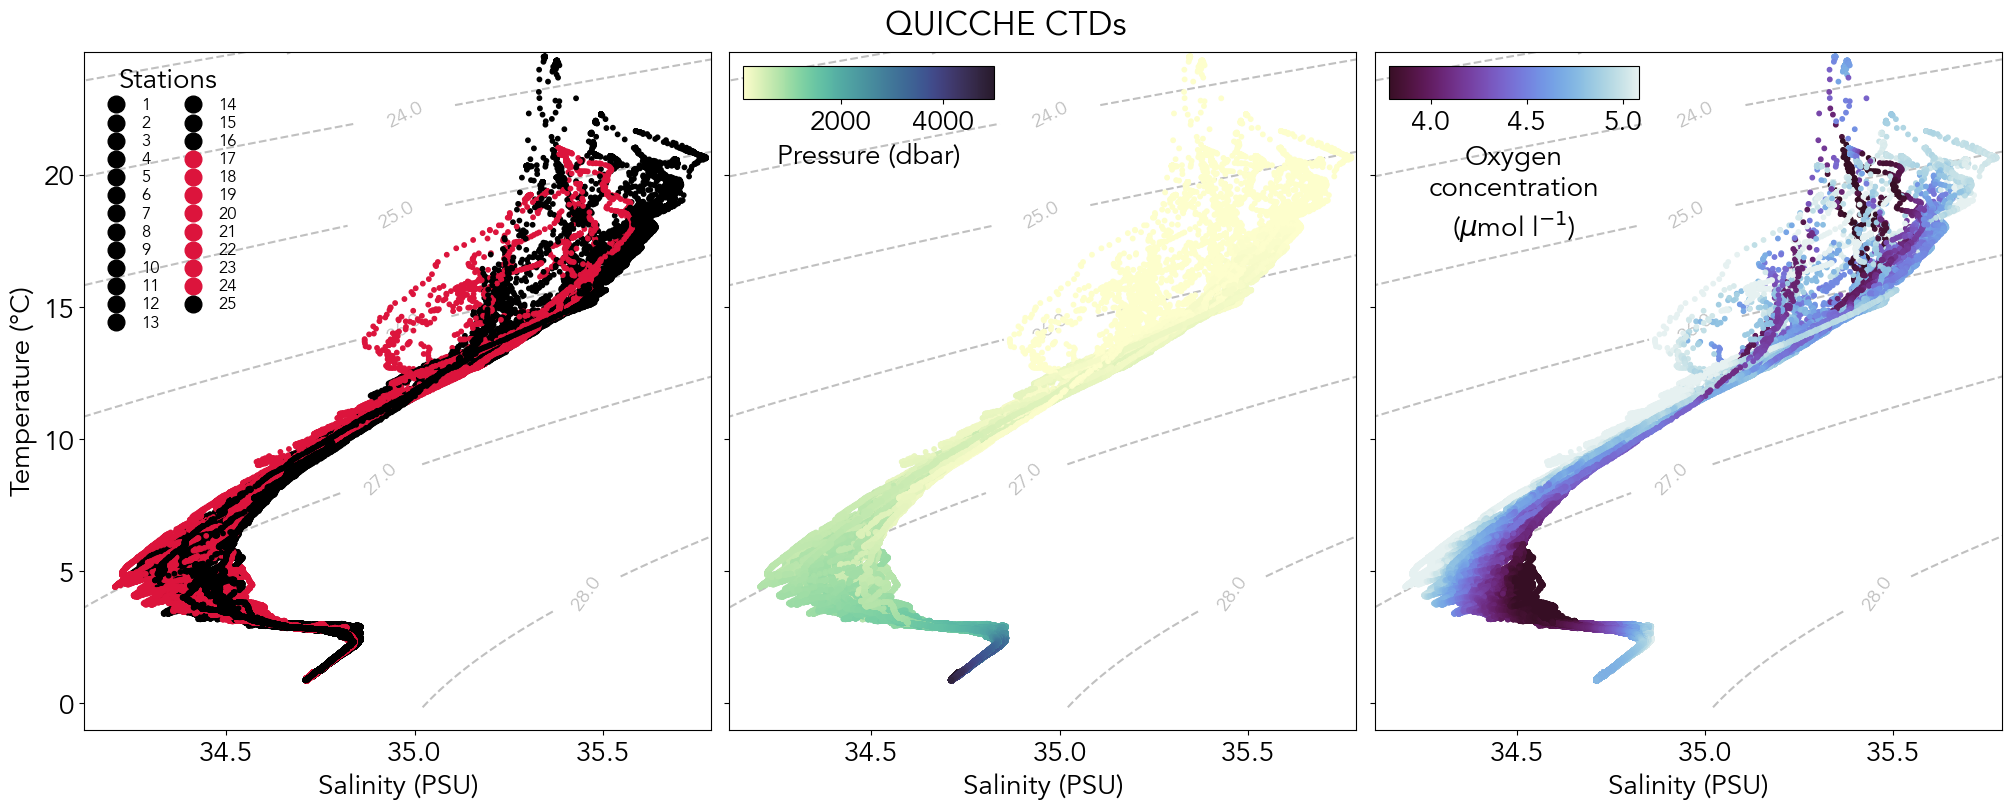

In [73]:
# Create a figure with three subplots
fig, ax = plt.subplots(1, 3, figsize=(20, 8), sharey=True, constrained_layout=True)

# Loop through each subplot
for i, axs in enumerate(ax):
    
    # Plot density lines
    cs = axs.contour(Sg, Tg, sigma_theta, colors='silver', linestyles='--', zorder=1)
    
    # Add labels to the contour lines
    cl = axs.clabel(cs, fontsize=14, inline=1, fmt='%.1f', zorder=1, inline_spacing=1e-9,
                     manual=[[34.7, 25], [35, 22], [35, 18], [35, 14], [35, 8], [35.5, 4]], use_clabeltext=True)
    
    # Set limits of the axes based on the data
    axs.set(xlim=[np.nanpercentile(ds['salinity1'], 1) - 0.2, np.nanpercentile(ds['salinity1'], 99) + 0.2],
            ylim=[np.nanpercentile(ds['temperature1'], 1) - 2, np.nanpercentile(ds['temperature1'], 99) + 5])

    # Create a scatter plot with the given data
    sct = ds.plot.scatter(x='salinity1',
                          y='temperature1',
                          hue=['station', 'pressure', 'oxygen_concentration_mll'][i],
                          s=10,
                          ax=ax[i],
                          cmap=[colors, cmo.deep, cmo.dense_r][i],
                          add_guide=False,
                          zorder=2,
                          robust=True)
    
    # If not the first subplot, add a colorbar
    if i > 0:
        axins = inset_axes(axs, width="40%", height="5%", loc='upper left')
        cb = plt.colorbar(sct, cax=axins, pad=0.01,
                           label=['Pressure (dbar)', 'Oxygen\nconcentration\n($\mu$mol l$^{-1}$)'][i - 1],
                           orientation="horizontal", aspect=0.01)
        cb.ax.invert_yaxis()
    
    # Set the x and y labels and title for each subplot
    axs.set(xlabel=('Salinity (PSU)'),ylabel=['Temperature (°C)','',''][i],title='',xticks=np.arange(34.5,35.51,0.5))

for i in range(n):
    ax[0].scatter(100,100,c=[colors(1+i)[:3]],label=f'{i+1}')

ax[0].legend(ncol=2,
          labelspacing=0.1,
          handletextpad=0.5,
          fontsize=12,
          loc='upper left',
          columnspacing=1,
          frameon=False,
          #bbox_to_anchor=[1,1,0.3,0.025],
          title='Stations',
          markerscale=2)

fig.suptitle('QUICCHE CTDs')
plt.show()

# **3. Plot profiles**

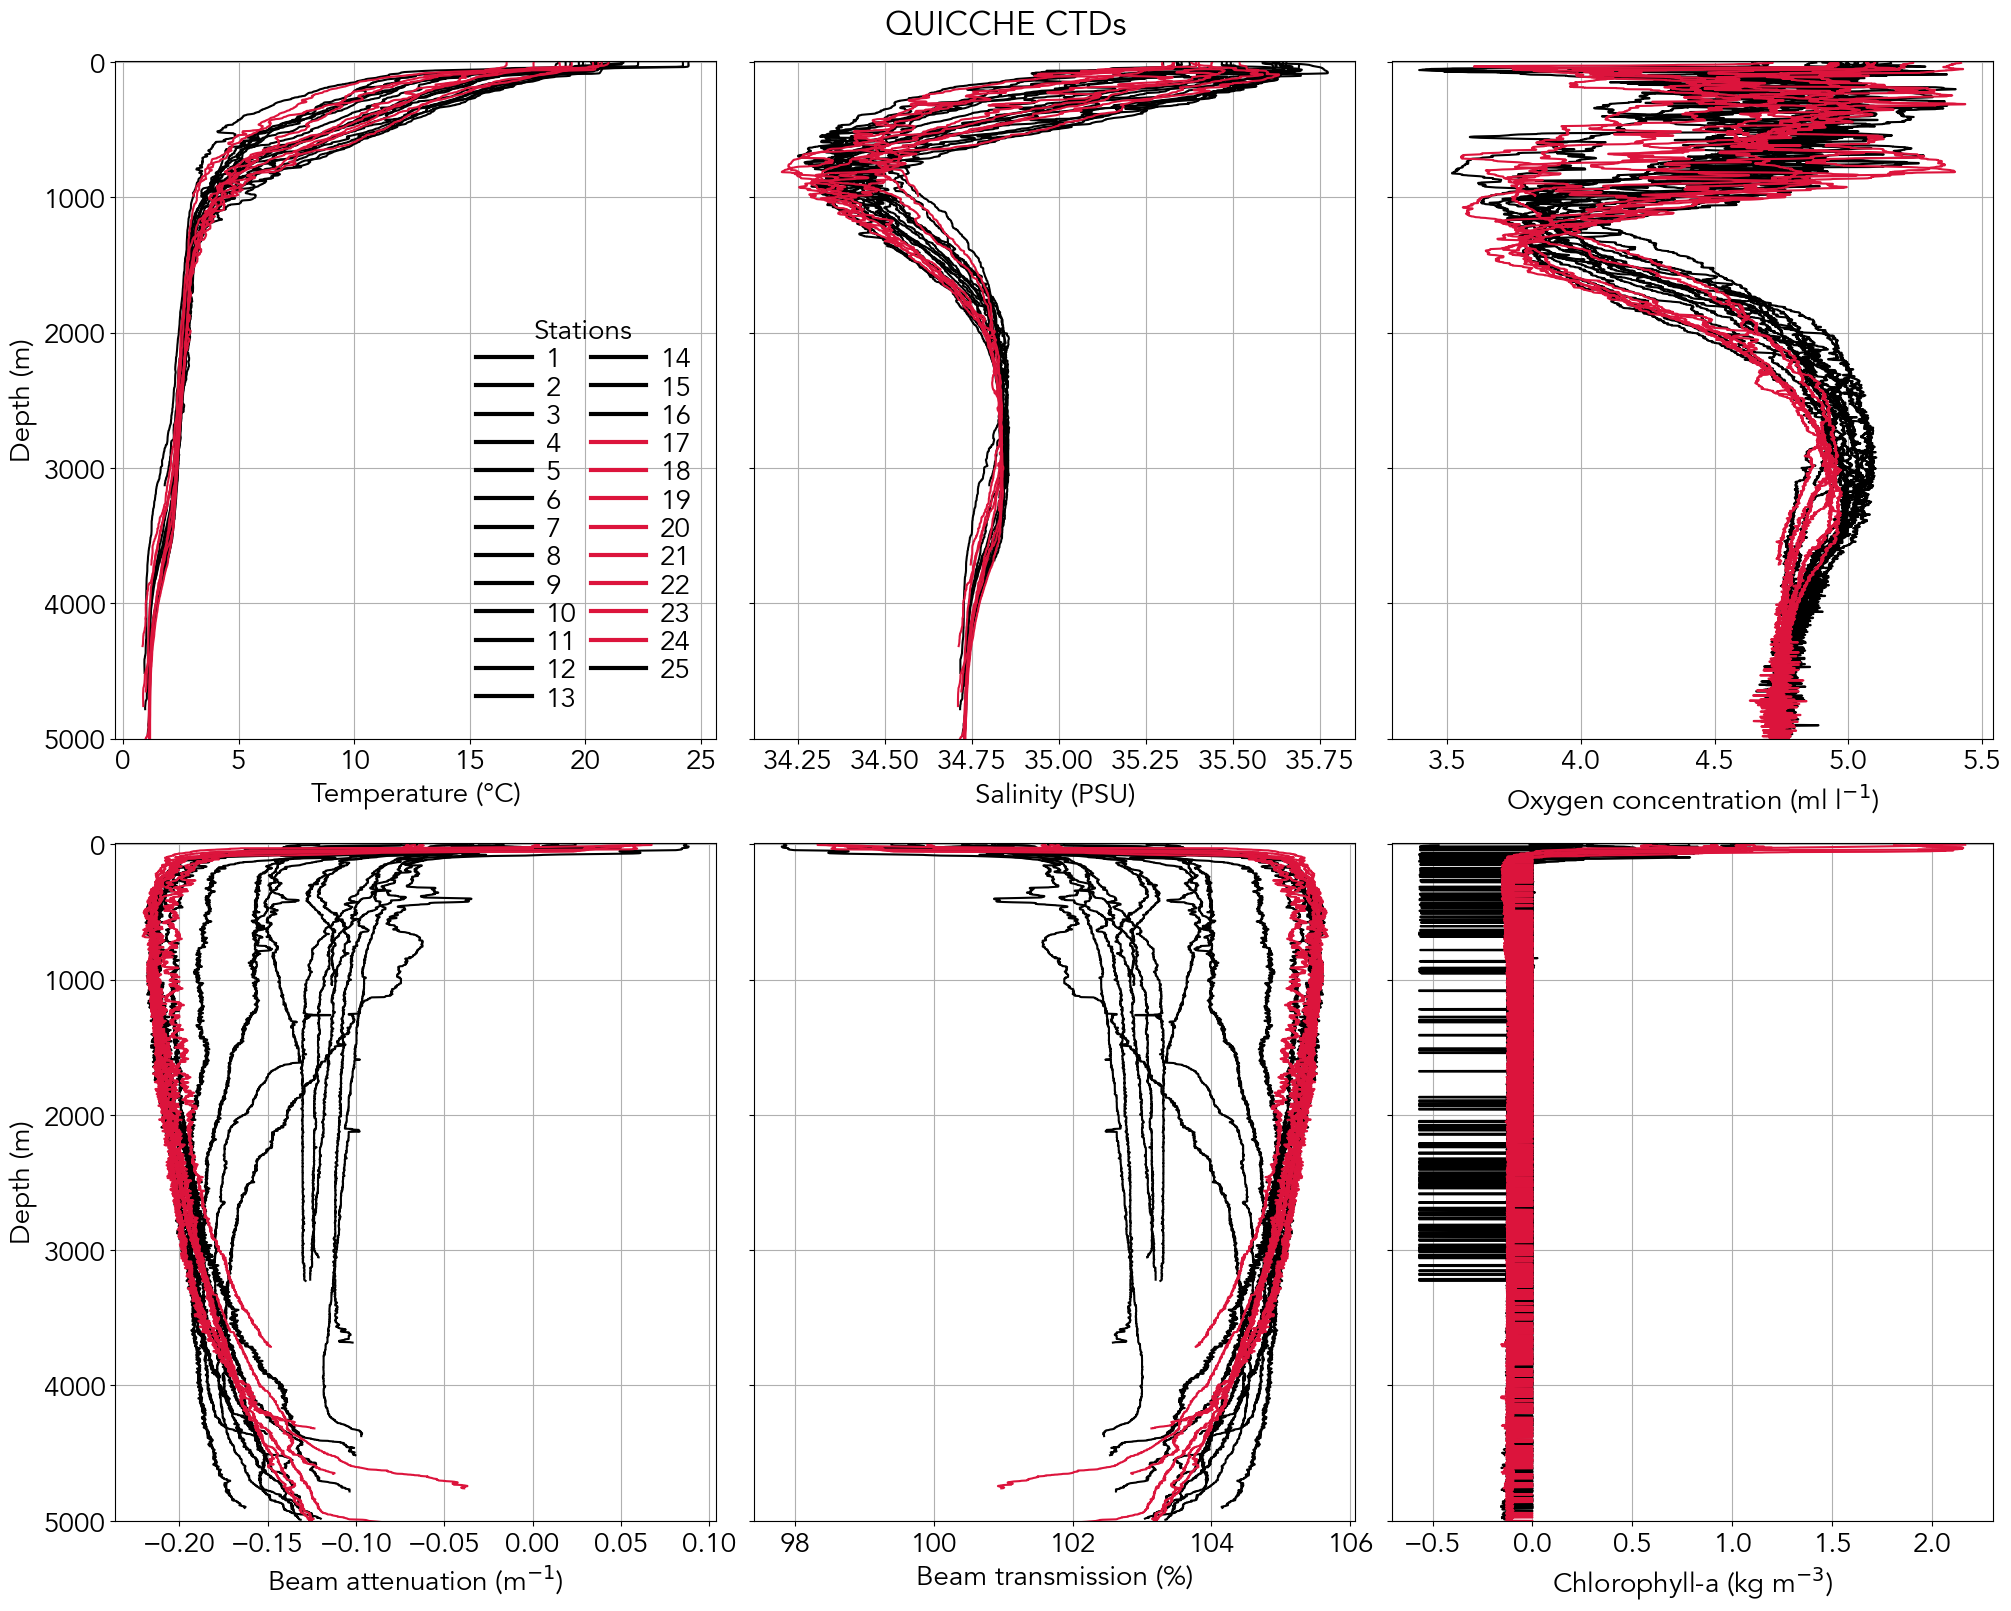

In [74]:
y = 5000
n = ds.station.max().values
cmap = plt.get_cmap('viridis',n)
var = ['temperature1','salinity1','oxygen_concentration_mll','beam_attenuation','beam_transmission','chlorophyll']
legends = []

fig,ax=plt.subplots(2,3,figsize=(20,16),sharey=True,constrained_layout=True)
ax=ax.flatten()

for i in range(n):
    for j in range(len(var)):
        ds[var[j]].sel(station=i+1,cast='down').squeeze().rolling(pressure=5,center=True).median('pressure').plot(y='pressure',hue='station',ax=ax[j],ylim=(y,-10),c=colors(0+i)[:3])
        ax[j].set(title='',ylabel=['Depth (m)','','','Depth (m)','',''][j],xlabel=['Temperature (°C)',
                                                                                   'Salinity (PSU)',
                                                                                   'Oxygen concentration (ml l$^{-1}$)',
                                                                                   'Beam attenuation (m$^{-1}$)',
                                                                                   'Beam transmission (%)',
                                                                                   'Chlorophyll-a (kg m$^{-3}$)'][j])
        ax[j].grid()
        
    legends.append(Line2D([0], [0], color=colors(1+i)[:3], lw=3, label=f'{1+i}'))
    
ax[0].legend(handles=legends,
             ncol=2,
             labelspacing=0.01,
             handletextpad=0.5,
             fontsize=20,
             loc='lower right',
             columnspacing=.5,
             frameon=False,
             title='Stations')

fig.suptitle('QUICCHE CTDs')
plt.show()

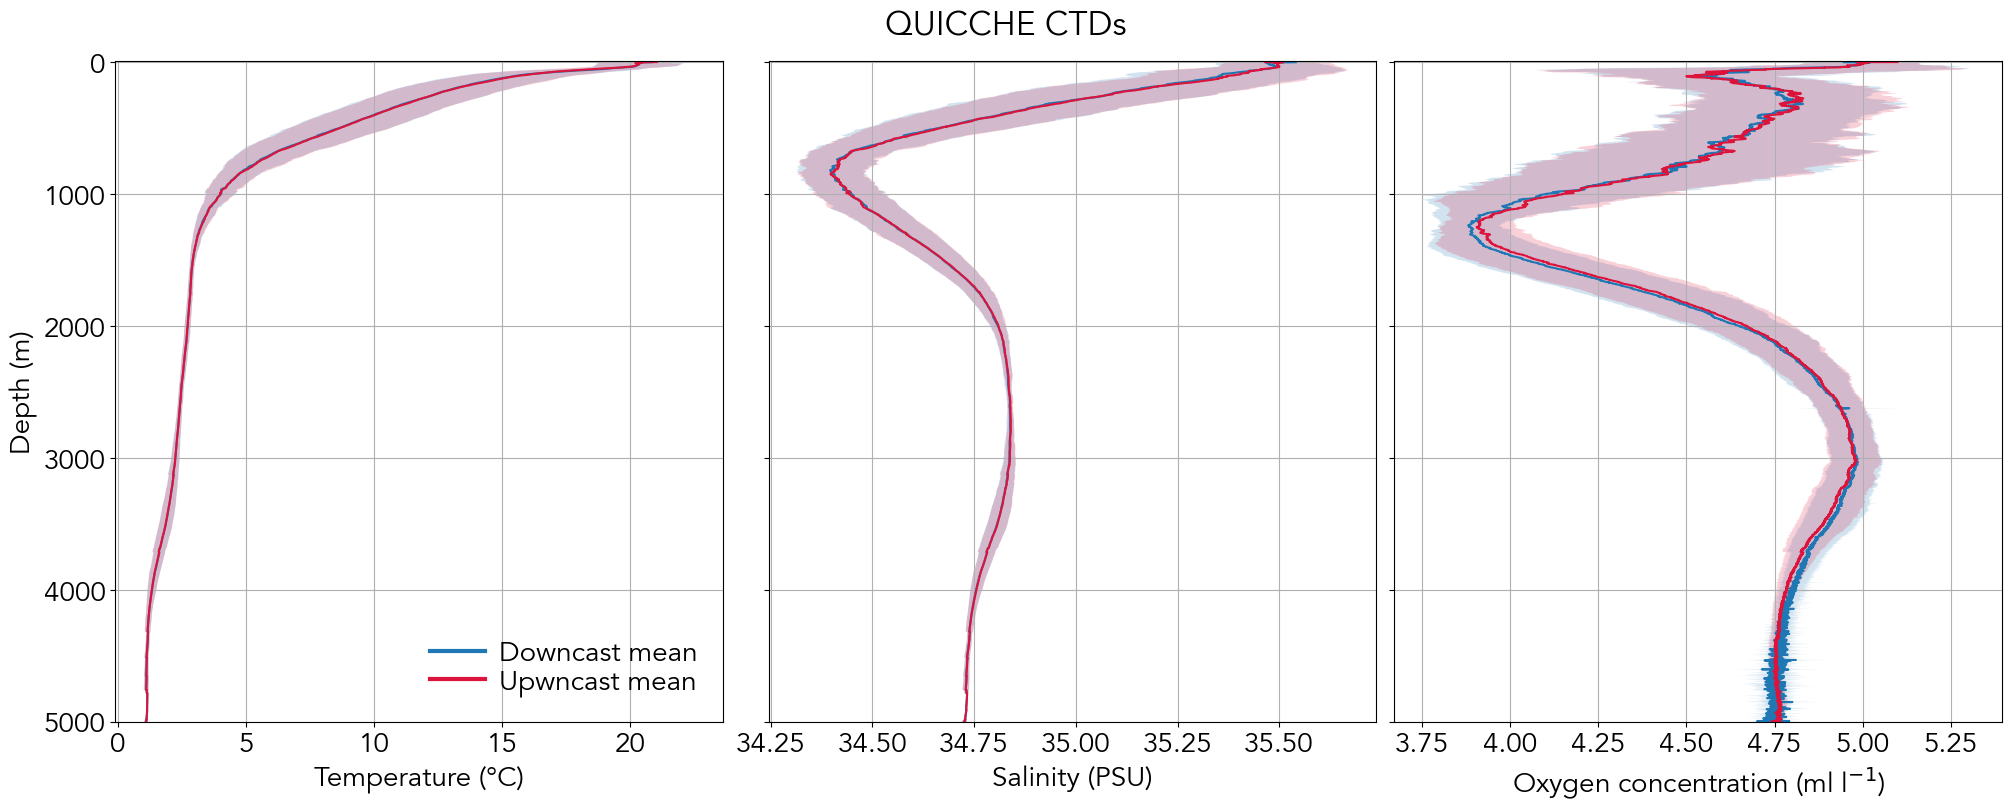

In [89]:
y = 5000
n = ds.station.max().values
cmap = plt.get_cmap('viridis',n)
var = ['temperature1','salinity1','oxygen_concentration_mll']
legends = []

fig,ax=plt.subplots(1,3,figsize=(20,8),sharey=True,constrained_layout=True)
ax=ax.flatten()

for j in range(len(var)):
    ds.sel(cast='down').mean('station')[var[j]].plot(y='pressure',ax=ax[j],ylim=(y,-10))
    ax[j].fill_betweenx(ds.pressure,
                        (ds.sel(cast='down').mean('station')[var[j]]-ds.sel(cast='down').std('station')[var[j]]).squeeze(),
                        (ds.sel(cast='down').mean('station')[var[j]]+ds.sel(cast='down').std('station')[var[j]]).squeeze(),zorder=1,alpha=0.2,)

    
    ds.sel(cast='up').mean('station')[var[j]].plot(y='pressure',ax=ax[j],ylim=(y,-10),c='crimson')
    ax[j].fill_betweenx(ds.pressure,
                        (ds.sel(cast='up').mean('station')[var[j]]-ds.sel(cast='up').std('station')[var[j]]).squeeze(),
                        (ds.sel(cast='up').mean('station')[var[j]]+ds.sel(cast='up').std('station')[var[j]]).squeeze(),zorder=1,alpha=0.2,fc='crimson',)

    
    ax[j].set(title='',ylabel=['Depth (m)','','','Depth (m)','',''][j],
              xlabel=['Temperature (°C)',
                       'Salinity (PSU)',
                       'Oxygen concentration (ml l$^{-1}$)',
                       'Beam attenuation (m$^{-1}$)',
                       'Beam transmission (%)',
                       'Chlorophyll-a (kg m$^{-3}$)'][j])
    ax[j].grid()

legends = []
legends.append(Line2D([0], [0], color='C0', lw=3, label='Downcast mean'))    
legends.append(Line2D([0], [0], color='crimson', lw=3, label='Upwncast mean'))    

ax[0].legend(handles=legends,
             ncol=1,
             labelspacing=0.01,
             handletextpad=0.5,
             fontsize=20,
             loc='lower right',
             columnspacing=.5,
             frameon=False)

fig.suptitle('QUICCHE CTDs')
plt.show()